# model using logistic regression

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import copy as cp
import math as mt
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



In [5]:
from google.colab import drive
from pathlib import Path
import pandas as pd

drive.mount('/content/drive')

# Try the most common locations first
candidate_paths = [
    Path('/content/drive/MyDrive/titanic/train.csv'),
    Path('/content/drive/MyDrive/Titanic/train.csv'),
    Path('/content/drive/MyDrive/Kaggle/titanic/train.csv'),
]

train_path = next((path for path in candidate_paths if path.exists()), None)

# Fallback: search your Drive for train.csv
if train_path is None:
    matches = list(Path('/content/drive/MyDrive').rglob('train.csv'))
    if not matches:
        raise FileNotFoundError(
            "train.csv not found in Google Drive. Upload it to Drive and update the folder path."
        )
    train_path = matches[0]

print(f'Using dataset: {train_path}')
train_ds = pd.read_csv(train_path)
X_train = train_ds.drop('Survived', axis=1)
y_train = train_ds['Survived']

Mounted at /content/drive
Using dataset: /content/drive/MyDrive/Colab Notebooks/train.csv


In [6]:
train_ds.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [7]:
X_train=X_train.drop(["Cabin"],axis=1)

In [8]:
X_train


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...
886,887,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S
887,888,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S
888,889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,S
889,890,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C


In [9]:
print(y_train.head(2))

0    0
1    1
Name: Survived, dtype: int64


In [10]:
X_train["Age"] = X_train["Age"].fillna(X_train["Age"].median())
X_train["Embarked"]=X_train["Embarked"].fillna(X_train["Embarked"].mode()[0])

In [11]:
X_train.isnull().sum()

,0
PassengerId,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0
Embarked,0


# Dropping un-neccasary Columns for prediction

In [12]:
future_use=X_train[["PassengerId","Name","Ticket"]]
future_use.head(2)

,PassengerId,Name,Ticket
0,1,"Braund, Mr. Owen Harris",A/5 21171
1,2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599


In [13]:
X_train=X_train.drop(["PassengerId","Name","Ticket"],axis=1)


In [14]:
X_train.head(12)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S
5,3,male,28.0,0,0,8.4583,Q
6,1,male,54.0,0,0,51.8625,S
7,3,male,2.0,3,1,21.0750,S
8,3,female,27.0,0,2,11.1333,S
9,2,female,14.0,1,0,30.0708,C


# COMBINING ALL FAMILY PERSONS

In [15]:
X_train["family_size"]=X_train["SibSp"]+X_train["Parch"]+1
X_train=X_train.drop(["SibSp","Parch"],axis=1)

In [16]:
X_train["Sex"]=X_train["Sex"].map({"female":1,"male":0})
X_train.head(2)



,Pclass,Sex,Age,Fare,Embarked,family_size
0,3,0,22.0,7.2500,S,2
1,1,1,38.0,71.2833,C,2


In [17]:
X_train = pd.get_dummies(X_train, columns=["Embarked"], dtype=int)

In [18]:
X_train.head(10)

,Pclass,Sex,Age,Fare,family_size,Embarked_C,Embarked_Q,Embarked_S
0,3,0,22.0,7.2500,2,0,0,1
1,1,1,38.0,71.2833,2,1,0,0
2,3,1,26.0,7.9250,1,0,0,1
3,1,1,35.0,53.1000,2,0,0,1
4,3,0,35.0,8.0500,1,0,0,1
5,3,0,28.0,8.4583,1,0,1,0
6,1,0,54.0,51.8625,1,0,0,1
7,3,0,2.0,21.0750,5,0,0,1
8,3,1,27.0,11.1333,3,0,0,1
9,2,1,14.0,30.0708,2,1,0,0


In [19]:
X_train.head(2)

,Pclass,Sex,Age,Fare,family_size,Embarked_C,Embarked_Q,Embarked_S
0,3,0,22.0,7.2500,2,0,0,1
1,1,1,38.0,71.2833,2,1,0,0


In [20]:
X_train["Fare"].describe()

,Fare
count,891.000000
mean,32.204208
std,49.693429
min,0.000000
25%,7.910400
50%,14.454200
75%,31.000000
max,512.329200


In [21]:
X_train.describe()

,Pclass,Sex,Age,Fare,family_size,Embarked_C,Embarked_Q,Embarked_S
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,0.352413,29.361582,32.204208,1.904602,0.188552,0.086420,0.725028
std,0.836071,0.477990,13.019697,49.693429,1.613459,0.391372,0.281141,0.446751
min,1.000000,0.000000,0.420000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,22.000000,7.910400,1.000000,0.000000,0.000000,0.000000
50%,3.000000,0.000000,28.000000,14.454200,1.000000,0.000000,0.000000,1.000000
75%,3.000000,1.000000,35.000000,31.000000,2.000000,0.000000,0.000000,1.000000
max,3.000000,1.000000,80.000000,512.329200,11.000000,1.000000,1.000000,1.000000


# SPLITTING TEST AND TRAIN DATA_SET

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# feature engineering

In [23]:
X_train['Fare_per_person'] = X_train['Fare'] / (X_train['family_size'] + 1)
X_test['Fare_per_person'] = X_test['Fare'] / (X_test['family_size'] + 1)

# after split only on training data (to avoid data leakage).
just doing feature scaling on age fare and family size as they vary alot

In [27]:
numeric_features = ["Age", "Fare", "family_size","Fare_per_person"]
scaler=StandardScaler()
X_train[numeric_features]=scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features]=scaler.transform(X_test[numeric_features])

In [28]:
X_train.head(2)

,Pclass,Sex,Age,Fare,family_size,Embarked_C,Embarked_Q,Embarked_S,Fare_per_person
692,3,0,-0.112078,0.513812,-0.556339,0,0,1,0.843587
481,2,0,-0.112078,-0.662563,-0.556339,0,0,1,-0.589519


In [29]:
X_test.head(2)

,Pclass,Sex,Age,Fare,family_size,Embarked_C,Embarked_Q,Embarked_S,Fare_per_person
565,3,0,-0.41917,-0.159704,0.703162,0,0,1,-0.283218
160,3,0,1.11629,-0.327324,0.073412,0,0,1,-0.317251


In [30]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


In [31]:
def compute_cost(X, y, theta):
    m = len(y)
    h = sigmoid(X @ theta)
    cost = -(1/m) * (y.T @ np.log(h) + (1 - y).T @ np.log(1 - h))
    return cost

In [36]:
cost_history = compute_cost(X_train, y_train, np.zeros(X_train.shape[1]))
print(f'Initial cost: {cost_history}')

Initial cost: 0.6931471805599452


In [41]:
def gradient_descent(X, y, theta, alpha, iterations):
    m = len(y)
    cost_history = []

    for i in range(iterations):
        h = sigmoid(X @ theta)
        gradient = (1/m) * (X.T @ (h - y))
        theta = theta - alpha * gradient

        cost = compute_cost(X, y, theta)
        cost = float(np.squeeze(cost))   # ensures scalar for clean printing
        cost_history.append(cost)

        if (i + 1) % 1000 == 0:
            print(f"Iteration {i+1}: Cost = {cost:.6f}")

    return theta, cost_history

In [ ]:

theta_final, cost_history = gradient_descent(
    X_train, y_train, 
    np.zeros(X_train.shape[1]), 
    alpha=0.01, 
    iterations=50000
)

print(f"Final theta shape: {theta_final.shape}")
print(f"\nFinal theta values:\n{theta_final}")

Iteration 1000: Cost = 0.506914
Iteration 2000: Cost = 0.471765
Iteration 3000: Cost = 0.456674
Iteration 4000: Cost = 0.449465
Iteration 5000: Cost = 0.445752
Iteration 6000: Cost = 0.443701


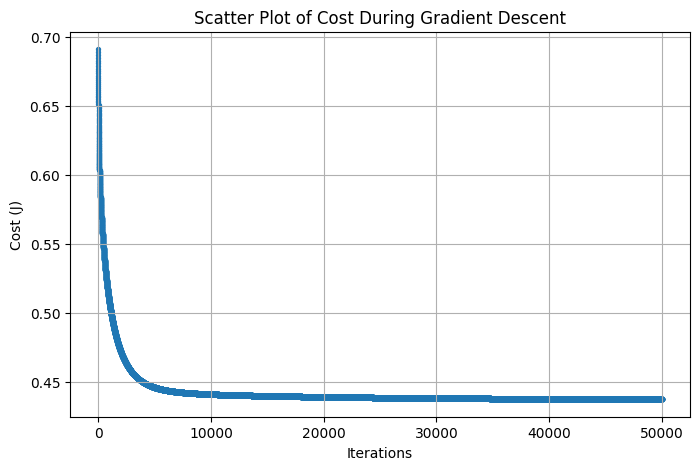

In [44]:
plt.figure(figsize=(8,5))
plt.scatter(range(len(cost_history)), cost_history, s=8)
plt.xlabel("Iterations")
plt.ylabel("Cost (J)")
plt.title("Scatter Plot of Cost During Gradient Descent")
plt.grid(True)
plt.show()